<a href="https://colab.research.google.com/github/jngadiub/ML_course_Pavia_23_WIP/blob/main/PartT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jet Tagging with Visual Transformer

In this notebook we will see an implementation of the Transformer architecture for sets applied to the jet tagging task. For *sets* it is meant here a point cloud, i.e. a set of nodes without edges. We will instead use Multi-Head Attention to learn which nodes (or particles) have strong pair-wise interaction.

The architecture was introduced by [J. Lee at al. (ICML 2019)](https://arxiv.org/abs/1810.00825) --  specifically designed to model interactions among elements in the input set without pre-defined edges. The model consists of an encoder and a decoder, both of which rely on attention mechanisms, as in the original Transformer implementation [by Vaswani](https://arxiv.org/abs/1706.03762). The main difference is that positional encoding is removed plus some other low level adaptions.

We will use tensorflow for this implementation.

Before you start, choose GPU as a hardware accelerator for this notebook. To do this first go to Edit -> Notebook Settings -> Choose GPU as a hardware accelerator.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import h5py
import numpy as np
import matplotlib.pyplot as plt

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Initialize GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
device_to_use = 0

if gpus:
    try:
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(
            logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('No GPU available, using the CPU')

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## Dataset exploration

In [3]:
! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
! tar -xvzf Data-MLtutorial.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-MLtutorial.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  66.3M      0 --:--:--  0:00:05 --:--:-- 88.4M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


*   'jetImage' ,' jetImageECAL' and 'jetImageHCAL' contains the image representation of the jets  . We will not use them today but build our point cloud from the other information.
*   'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored. This is the dataset we will consider in this notebook.
*   'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
*   'jets' is the list of jets with the high-level jet features stored. We will only use jet ID from it, indecies [-6:-1]
*   'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'. These quantities are build using physics knowledge and correspond to high-level infromation and features per graph (as opposed to per node)

The first 100 highest transverse momentum $p_T$ particles are considered for each jet.



In [4]:
import glob

target_onehot = np.array([])
jetList = np.array([])
jetImages = np.array([])
features_names = dict()
# datafiles = ['jetImage_7_100p_0_10000.h5',
#              'jetImage_7_100p_10000_20000.h5',
#              'jetImage_7_100p_30000_40000.h5',
#              'jetImage_7_100p_40000_50000.h5',
#              'jetImage_7_100p_50000_60000.h5'
#             ]

datafiles = glob.glob('Data-MLtutorial/JetDataset/*.h5')
N = 3
for i_f,fileIN in enumerate(datafiles[:N]):
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    # jetList_file = np.array(f.get("jetImage"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    jetImages_file = np.array(f.get('jetImage'))
    # jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target_onehot = np.concatenate([target_onehot, target_file], axis=0) if target_onehot.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    del target_file, jetImages_file
    #save particles/nodes features names and their indecies in a dictionary
    # if i_f==0:
    #     for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
    #         features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5


The ground truth is incorporated in the ['j_g', 'j_q', 'j_w', 'j_z', 'j_t] vector of boolean, taking the form
*  [1, 0, 0, 0, 0] for gluons
*  [0, 1, 0, 0, 0] for quarks
*  [0, 0, 1, 0, 0] for W
*  [0, 0, 0, 1, 0] for Z
*  [0, 0, 0, 0, 1] for top quarks

This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems). These labels are the 'target' for our classification tasks. Let's convert it back to single-column encoding :


In [5]:
# print("Labels for the first five entries in the dataset, one-hot encoded:")
# for i in range(5):
#     print(target_onehot[i])
# print(target_onehot.shape)
target = np.argmax(target_onehot, axis=1)
print(target.shape)
print("Labels for the first five entries in the dataset, single column encoded:")
for i in range(0,5):
    print(target[i])

(30000,)
Labels for the first five entries in the dataset, single column encoded:
1
2
4
4
4


Now our lables correspond to :
*  0 for gluons
*  1 for quarks
*  2 for W
*  3 for Z
*  4 for top quarks


In [6]:
num_classes = len(np.unique(target))
label_names= ["gluon", "quark", "W", "Z", "top"]

Now let's inspect our data. Each jet is a point cloud/graph with 100 particles/nodes, each of which has 16 features. We have a double-index dataset: (jet index, particle index). The list is cut at 100 constituents per jet. If less constituents are present in the jet/point cloud, the dataset is completed filling it with 0s (zero padding). Note : zero-padding is not using during the training, it is only used to store the ragged dataset.



In [7]:
print('Jet Images shape : ',jetImages.shape)
print('Target/Labels shape : ',target.shape)
# print('Particles/Nodes features : ',list(features_names.keys()))

Jet Images shape :  (30000, 100, 100)
Target/Labels shape :  (30000,)


In [12]:
# Normalize the data
def minMaxScaleIMG(X, feature_range=(0, 1)):
    min_val = np.min(X)
    max_val = np.max(X)
    scale = (feature_range[1] - feature_range[0]) / (max_val - min_val)
    return scale * (X-min_val) + feature_range[0]

jetImages = minMaxScaleIMG(jetImages)
# X_train = minMaxScaleIMG(X_train)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    jetImages, target, test_size=0.1, shuffle=True)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del jetImages, target, target_onehot

(27000, 100, 100) (3000, 100, 100) (27000,) (3000,)


Min 0.0, Max: 179.4117307394644


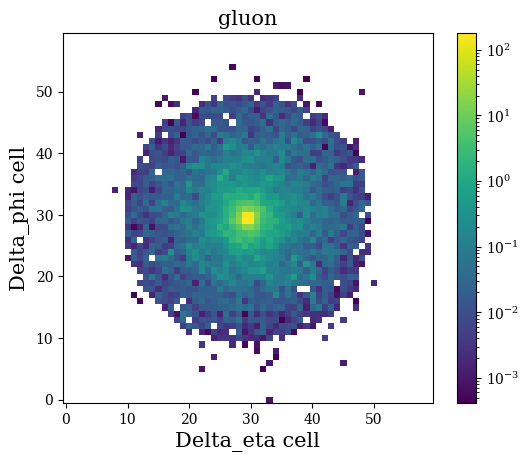

Min 0.0, Max: 120.53230486664117


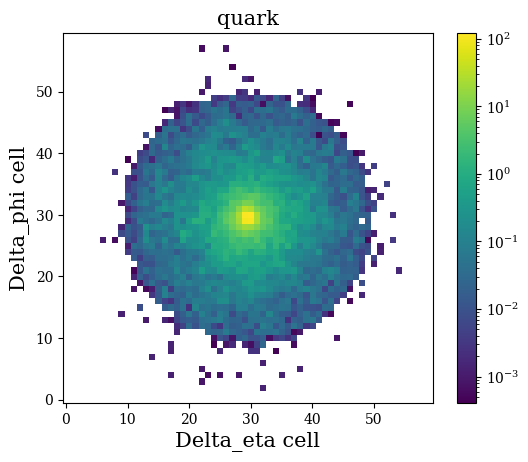

Min 0.0, Max: 44.32478881225562


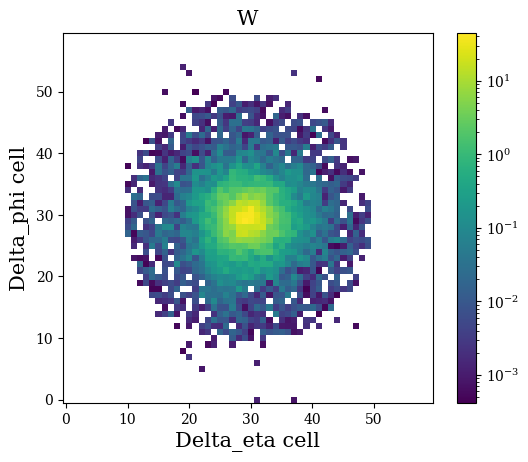

Min 0.0, Max: 44.7752655317386


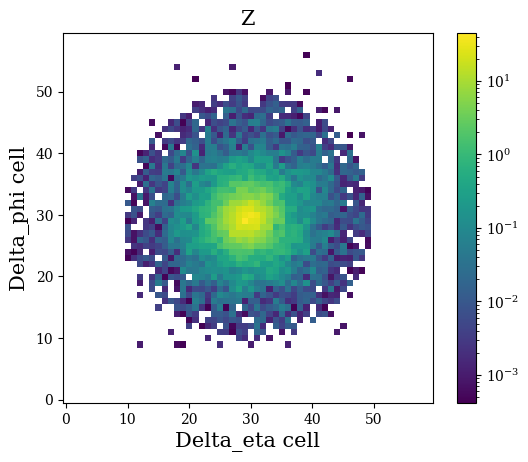

Min 0.0, Max: 12.62747634909222


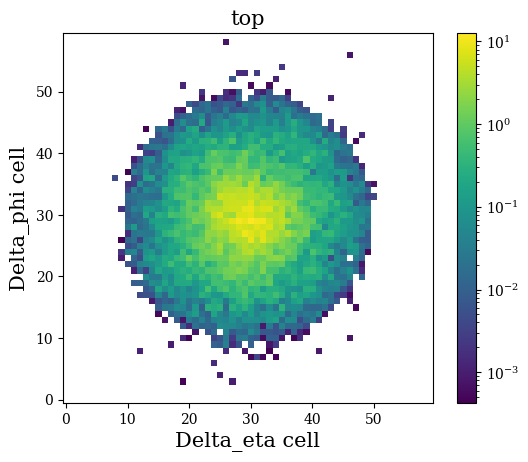

In [10]:
from matplotlib.colors import LogNorm
labelCat= ["gluon", "quark", "W", "Z", "top"]
image = X_val
image_g = image[y_val == 0]
image_q = image[y_val == 1]
image_W = image[y_val == 2]
image_Z = image[y_val == 3]
image_t = image[y_val == 4]
images = [image_q, image_g, image_W, image_Z, image_t]
#plt.rc('text', usetex=True) #you can uncomment this if you have a latex installation
plt.rc('font', family='serif')
crop = 20
for i in range(len(images)):
    SUM_Image = np.sum(images[i], axis = 0) / float(images[i].shape[0])
    print(f'Min {np.min(SUM_Image)}, Max: {np.max(SUM_Image)}')
    plt.imshow(SUM_Image[crop:-crop, crop:-crop], origin='lower',norm=LogNorm())
    plt.colorbar()
    plt.title(labelCat[i], fontsize=15)
    plt.xlabel("Delta_eta cell", fontsize=15)
    plt.ylabel("Delta_phi cell", fontsize=15)
    plt.show()

## Multi Head Attention recap

Assume we have $n$ query vectors (corresponding to the $n$ elements in the set) each with dimension $d_q : Q \in \mathbb{R}^{n\times d_q}$. In the jet tagging dataset $n=100$ and $d_q=7$.

An attention function $\mathrm{Att}(Q,K,V)$ is a function that maps queries $Q$ to outputs using $n_v$ key-value pairs $K \in \mathbb{R}^{n_v \times d_q}, V \in \mathbb{R}^{n_v\times d_v}$:

$$
\mathrm{Att}(Q,K,V;\omega) = \omega(QK^{T})V.
$$

The pairwise dot product $QT^\mathrm{T} \in \mathbb{R}^{n\times n_v}$ measures how similar each pair of query and key vectors is, with weights computed with an activation function $\omega$. The output $\omega(QK^{T})V$ is a weighted sum of $V$ where a value gets more weight if its corresponding key has larger dot product with the query.

Instead of computing a single attention function, the **multi-head attention** method first projects $Q, K, V$ onto $h$ different $d^M_q,d^M_q,d^M_v$-dimensional vectors, respectively. An attention function $\mathrm{Att}(\cdot; \omega_j)$ is applied to each of these $h$ projections. The output is a linear transformation of the concatenation of all attention outputs:

$$
\mathrm{Multihead}(Q, K, V ; \lambda, \omega) = \mathrm{concat}(O_1,..., O_h)W^O
$$

$$
O_j = \mathrm{Att}(QW^Q_j, KW^K_j, VW^V_j ; \omega_j )
$$

In other words, the model tells you what is the score of a particle in the set knowing its interaction with the other particles in the set given all features but in a way that the features are attended separately.

Note that $\mathrm{Multihead}(\cdot, \cdot, \cdot; \lambda)$ has learnable parameters $\lambda =$ {$W^Q_j, W^K_j, W^V_j$}$_{j=1,...,h}$ where $W^Q_j, W^K_j \in \mathbb{R}^{d_q\times d^M_q}, W^V_j \in \mathbb{R}^{d_v\times d^M_v}, W^O \in \mathbb{R}^{hd^M_v\times d}$. A typical choice for the dimension hyperparameters is $d^M_q = d_q /h, d^M_v = d_v /h, d = d_q$. For the Set Transformer we set $d_q = d_v = d$ and $d^M_q = d^M_v = d/h$. A scaled softmax $\omega_j (\cdot) = \mathrm{softmax}(\cdot/\sqrt{d})$ is used.


## Building the Set Transformer

We will implement a simplified version of the [original Set Transformer architecture](https://arxiv.org/abs/1810.00825). The reason is because Transformers are typically computationally and data hungry. As an optional excercise at the end of the notebook you can try to implement the full model and test it on a simpler problem like the MNIST dataset classification (or on a larger jet class dataset).

The architecture is based on the block called `MAB` (= Multihead Attention Block) which implements the following:

$$
\mathrm{MAB}(X, Y) = \mathrm{LayerNorm}(H + \mathrm{rFF}(H))
$$

$$
H = \mathrm{LayerNorm}(X + \mathrm{Multihead}(X, X, X ; ω))
$$

where $X \in \mathbb{R}^{n\times d}$ is the input set and $\mathrm{rFF}$ is any feedforward layer. Since $Q=K=V=X$, the MAB takes a set and performs *self-attention* between the elements in the set, resulting in a set of equal size. Since the output of MAB contains information about pairwise interactions among the elements in the input set $X$, we can stack multiple MABs to encode higher order interactions. This stack is the *encoder* part of the transformer.

The `LayerNorm` normalizes the activations of a layer across the last dimension (feature dimension) of the input tensor. Specifically, it centers and scales each feature dimension independently by subtracting the mean and dividing by the standard deviation, which are computed over the corresponding feature dimension of the input tensor. As for `BatchNormalization` it has learnable $\gamma$ (scaling) and $\beta$ (shifting) parameters. The difference with respect to `BatchNormalization` is that the normalization is performed indipendently per each instance in the batch. `LayerNorm` leads to improved stability when you expect instances of different sizes (or different zero padding degree as in the jet tagging case).

In [14]:
def downsample(filters, kernel_size, apply_batchnorm=True, apply_dropout=0.0,
               use_bias=False, strides=2, padding='same', activation='relu',
               name=None):

    result = tf.keras.Sequential(name=name)
    result.add(
        tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding,
                               use_bias=use_bias))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout > 0 and apply_dropout < 1.0:
        result.add(tf.keras.layers.Dropout(apply_dropout))

    if activation == 'leakyrelu':
        result.add(tf.keras.layers.LeakyReLU())
    elif activation == 'relu':
        result.add(tf.keras.layers.ReLU())

    return result


def upsample(filters, kernel_size, apply_dropout=0.5, apply_batchnorm=True,
             strides=2, padding='same', activation='relu',
             use_bias=False, name=None):

    result = tf.keras.Sequential(name=name)
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides,
                                        padding=padding,
                                        use_bias=use_bias))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout > 0 and apply_dropout < 1.0:
        result.add(tf.keras.layers.Dropout(apply_dropout))

    if activation == 'leakyrelu':
        result.add(tf.keras.layers.LeakyReLU())
    elif activation == 'relu':
        result.add(tf.keras.layers.ReLU())

    return result


class Patches(layers.Layer):
    def __init__(self, patch_size, crop_size=0):
        super().__init__()
        self.patch_size = patch_size
        if isinstance(self.patch_size, int):
            self.patch_size = [self.patch_size] * 2
        self.crop_size = crop_size

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "crop_size": self.crop_size,
        })
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        if self.crop_size > 0:
            images = images[:, self.crop_size:-self.crop_size,
                            self.crop_size:-self.crop_size, :]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size[0], self.patch_size[1], 1],
            strides=[1, self.patch_size[0], self.patch_size[1], 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # print(patches.shape)
        patch_dims = patches.shape[-1]
        # print('patch_dims', patch_dims)
        patches = tf.reshape(
            patches, [batch_size, patches.shape[1] * patches.shape[2], patch_dims])
        return patches

# Patch encoding layer


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection,
        })
        return config

# MLP with dropout


def mlp(x, hidden_units, dropout_rate, activation='relu', use_bias='False'):
    for units in hidden_units:
        x = layers.Dense(units, activation=activation, use_bias=use_bias)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Transformer(keras.Model):
    def __init__(self, output_name='jettag', input_shape=(100, 100, 1), cropping=0,
                 patch_size=8, projection_dim=16, transformer_layers=4, num_heads=12,
                 transformer_units=[256, 64], mlp_head_units=[256, 64],
                 dropout_attention=0.1, dropout_mlp=0.1, dropout_representation=0.5,
                 dropout_final=0.5, use_bias=False,
                 learning_rate=0.001, activation='gelu', **kwargs):
        super().__init__()

        self.output_name = output_name
        self.inputShape = input_shape
        inputs = layers.Input(shape=input_shape)

        # Create patches.
        patches = Patches(patch_size, cropping)(inputs)

        # Encode patches.
        encoded_patches = PatchEncoder(
            patches.shape[1], projection_dim)(patches)

        # Create multiple layers of the Transformer block.
        for _ in range(transformer_layers):
            # Layer normalization 1.
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=projection_dim, dropout=dropout_attention)(x1, x1)
            # Skip connection 1.
            x2 = layers.Add()([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            # MLP.
            x3 = mlp(x3, hidden_units=transformer_units,
                     dropout_rate=dropout_mlp, activation=activation)
            # Skip connection 2.
            encoded_patches = layers.Add()([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        representation = layers.LayerNormalization(
            epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(dropout_representation)(representation)
        # Add MLP.
        features = mlp(representation, hidden_units=mlp_head_units,
                       dropout_rate=dropout_final, use_bias=use_bias)
        # Classify outputs.
        outputs = layers.Dense(5, activation='linear', name='output')(features)
        # Create the Keras model.
        model = keras.Model(inputs=inputs, outputs=outputs)
        self.model = model

        # Also initialize the optimizer and compile the model
        model.compile(
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )
        # return model
    def predict(self, input):
        latent = self.model(input)
        return latent

    def load(self, weights_file):
        self.model = keras.models.load_model(weights_file)

    def save(self, weights_file):
        self.model.save(weights_file)

Let's define basics hyperparamters:

In [18]:
train_cfg = {
    'epochs': 10,
    'cropping': 18,
    'patch_size': 8,
    'projection_dim': 16,
    'transformer_layers': 3,
    'num_heads': 16,
    'activation': 'relu',
    'transformer_units': [64, 16],
    'mlp_head_units': [128, 32, 16],
    'dropout_attention': 0.,
    'dropout_mlp': 0.0,
    'dropout_representation': 0.0,
    'dropout_final': 0.0,
    'learning_rate': 1e-3,
    'use_bias': False,
    'batch_size': 128,
}

model = Transformer(**train_cfg)
print(model.model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 patches_4 (Patches)            (None, 64, 64)       0           ['input_5[0][0]']                
                                                                                                  
 patch_encoder_4 (PatchEncoder)  (None, 64, 16)      2064        ['patches_4[0][0]']              
                                                                                                  
 layer_normalization_19 (LayerN  (None, 64, 16)      32          ['patch_encoder_4[0][0]']  

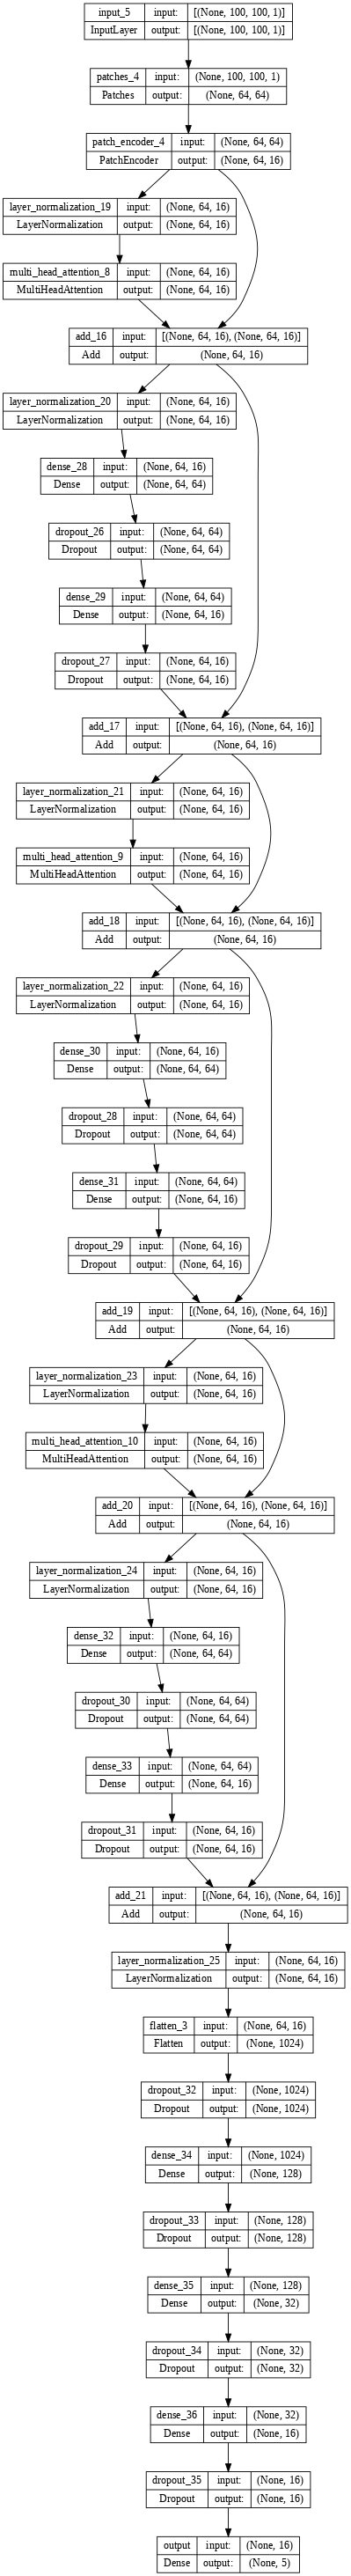

In [19]:
tf.keras.utils.plot_model(model.model, show_shapes=True, dpi=64)


In the original paper, multi-head attention is also applied in the decoder step to obtain a smarter pooling operation. For this excercise we will simplify the model and use instead a `Lambda` layer to apply a custom pooling function to the input tensor. In this case, the `Lambda` layer is being used to sum over the first dimension, i.e. over the elements in the output set of the previous layer, which has shape `(batch_size, n_elements, features)`. By summing over the first dimension (`axis=1`), we obtain a tensor of shape `(batch_size, features)` that represents an aggregation of each feature over the elements in the set.

Here is the full model:

In [ ]:
history = model.model.fit(X_train, y_train,
                    batch_size=train_cfg['batch_size'],
                    epochs=train_cfg['epochs'],
                    validation_data=(X_val, y_val))

Epoch 1/10
211/211 [==============================] - 22s 40ms/step - loss: 1.2952 - sparse_categorical_accuracy: 0.4401 - val_loss: 1.1978 - val_sparse_categorical_accuracy: 0.4893
Epoch 2/10
211/211 [==============================] - 7s 35ms/step - loss: 1.0652 - sparse_categorical_accuracy: 0.5548 - val_loss: 1.0480 - val_sparse_categorical_accuracy: 0.5653
Epoch 3/10
211/211 [==============================] - 8s 36ms/step - loss: 1.0205 - sparse_categorical_accuracy: 0.5772 - val_loss: 1.0189 - val_sparse_categorical_accuracy: 0.5783
Epoch 4/10
211/211 [==============================] - 7s 35ms/step - loss: 0.9913 - sparse_categorical_accuracy: 0.5954 - val_loss: 1.0098 - val_sparse_categorical_accuracy: 0.5957
Epoch 5/10
211/211 [==============================] - 8s 36ms/step - loss: 0.9689 - sparse_categorical_accuracy: 0.6073 - val_loss: 1.0230 - val_sparse_categorical_accuracy: 0.5757
Epoch 6/10
211/211 [==============================] - 8s 36ms/step - loss: 0.9521 - sparse_cat

We can now plot the validation and training loss evolution over the epochs:

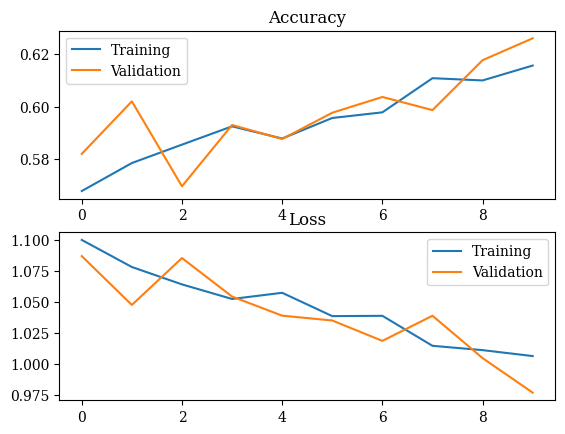

In [28]:
fig,axes = plt.subplots(2)

axes[0].plot(history.history["sparse_categorical_accuracy"])
axes[0].plot(history.history["val_sparse_categorical_accuracy"])
axes[0].set_title("Accuracy")
axes[0].legend(["Training", "Validation"])

axes[1].plot(history.history["loss"])
axes[1].plot(history.history["val_loss"])
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Loss")

fig.show()



Now we finally evaluate the performance by plotting the ROC curves for the different classes:

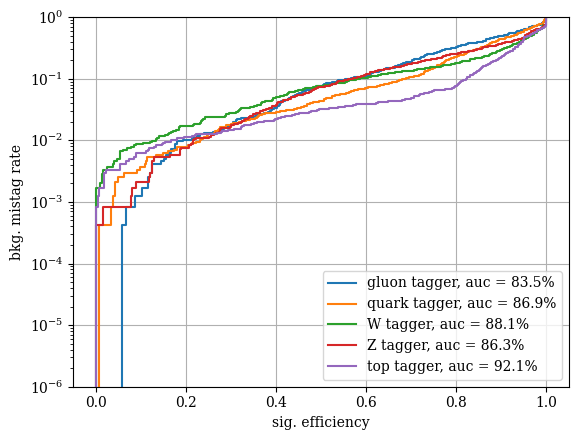

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
predict_val = tf.nn.softmax(model.predict(X_val))
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(label_names):

        df[label] = y_val_onehot[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

As you can see the performance are not as good for other models we have trained on the same dataset. As mentioned at the beginning of the notebook training a transformer might be tricky. You can try the optional excercise below to improve the performance and surpass the other models.

## Optional Excercise

The original paper also use MH mechanism in the decoder step (while we used a simple sum over the latent space nodes). If you would like to try it out the `Lambda` layer should be replaced with the `PoolingByMultiHeadAttention` block below.

Consider also the fact that it might be hard to train a Transformer architecture of this kind over the rather small dataset used here. Check out [this other dataset](https://events.mcs.cmu.edu/us-cms-2023/) for increased statistics or [this notebook](https://github.com/DLii-Research/tf-settransformer/blob/master/examples/mnist_pointcloud.ipynb) for a simpler task.

Below is the starting point for a smarter decoder:

In [ ]:
class PoolingByMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, hidden_units, mlp_hidden_units=128, num_seeds=1, **kwargs):
        super(PoolingByMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.hidden_units = hidden_units
        self.mlp_hidden_units = mlp_hidden_units
        self.num_seeds = num_seeds

    def build(self, input_shape):

        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=self.num_heads,
                                                            key_dim=self.hidden_units)

        self.seed_vectors = self.add_weight(
            shape=(1, self.num_seeds, self.hidden_units),
            initializer="random_normal",
            trainable=True,
            name="Seeds")

        self.feedforward = tf.keras.Sequential([
            layers.Dense(units=self.mlp_hidden_units, activation="relu"),
            layers.Dense(units=self.hidden_units)
        ])
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        super(PoolingByMultiHeadAttention, self).build(input_shape)

    def call(self, inputs, training=None):
        a = tf.expand_dims(self.seed_vectors, axis=0)
        seeds = tf.tile(self.seed_vectors, [tf.shape(inputs)[0], 1, 1])
        attention_output = self.attention(seeds, inputs)[0]
        attention_output = self.layer_norm1(seeds + attention_output)
        feedforward_output = self.feedforward(attention_output)
        block_output = self.layer_norm2(attention_output + feedforward_output)
        return block_output